In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, matthews_corrcoef
from sklearn.feature_selection import RFE, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR

import xgboost as xgb


%matplotlib inline



## Part 1: Load Data

In [372]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [3]:
X.head()

comp1_xt  comp1_xt-1  comp1_xt-2  comp1_xt-3  comp1_xt-4  comp1_xt-5  \
0 -0.049917   -0.015821   -0.014748   -0.020682    0.020328   -0.033654   
1  0.026143   -0.049917   -0.015821   -0.014748   -0.020682    0.020328   
2  0.045449    0.026143   -0.049917   -0.015821   -0.014748   -0.020682   
3  0.027492    0.045449    0.026143   -0.049917   -0.015821   -0.014748   
4 -0.026302    0.027492    0.045449    0.026143   -0.049917   -0.015821   

   comp1_xt-6  comp1_xt-7  comp1_xt-8  comp1_xt-9     ...       comp9_xt-11  \
0   -0.015738   -0.000337    0.012430   -0.007476     ...         -0.001938   
1   -0.033654   -0.015738   -0.000337    0.012430     ...          0.002906   
2    0.020328   -0.033654   -0.015738   -0.000337     ...          0.009625   
3   -0.020682    0.020328   -0.033654   -0.015738     ...         -0.007210   
4   -0.014748   -0.020682    0.020328   -0.033654     ...          0.012464   

   comp9_xt-12  comp9_xt-13  comp9_xt-14  comp9_xt-15  comp9_xt-16  \
0    -0.016799    -0.006168    -0.003306     0.005674    -0.010847   
1    -0.001938    -0.016799    -0.006168    -0.003306     0.005674   
2     0.002906    -0.001938    -0.016799    -0.006168    -0.003306   
3     0.009625     0.002906    -0.001938    -0.016799    -0.006168   
4    -0.007210     0.009625     0.002906    -0.001938    -0.016799   

   comp9_xt-17  comp9_xt-18  comp9_xt-19  comp9_xt-20  
0     0.003759     0.001413     0.014245    -0.026429  
1    -0.010847     0.003759     0.001413     0.014245  
2     0.005674    -0.010847     0.003759     0.001413  
3    -0.003306     0.005674    -0.010847     0.003759  
4    -0.006168    -0.003306     0.005674    -0.010847  

[5 rows x 189 columns]

In [4]:
PERFORMANCE_TRACKER = []  # will just keep track of model performances

In [5]:
y.head()

comp4_xt+1
0    0.008376
1   -0.001133
2    0.001854
3    0.000720
4    0.003592

In [6]:
X.shape

(2501, 189)

In [7]:
y.shape

(2501, 1)

<b> Let's make 20% for testing </b>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

## Part 2: Explore Various Regression Models and Find the Best to Predict  $x_{t+1}$

### Attempt Regression 1: Linear

In [9]:
linear_regr = LinearRegression().fit(X_train, y_train)
y_pred = linear_regr.predict(X_test)
linear_regr_error = mean_squared_error(y_test, y_pred)
linear_regr_rsquared = r2_score(y_test, y_pred)
print("Linear Regression MSE: {:.8f}".format(linear_regr_error))
print("Linear Regression R^2: {:.8f}".format(linear_regr_rsquared))

Linear Regression MSE: 0.00024097
Linear Regression R^2: -0.14099102


In [10]:
PERFORMANCE_TRACKER.append(("Linear Regression", linear_regr_error))

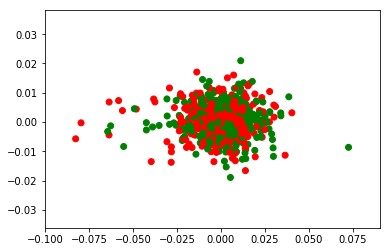

In [11]:
plt.scatter(y_test, y_pred, color=['r', 'g'])
plt.show()

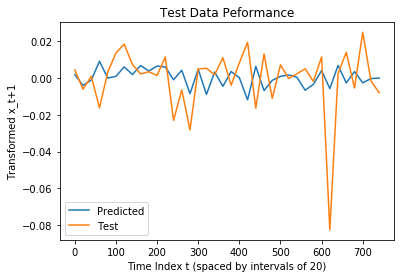

In [12]:
plt.plot(range(len(y_pred))[0:-1:20], y_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

### Linear With KFold

In [13]:
kf_linear_regr = LinearRegression()
score = -1 * cross_val_score(kf_linear_regr, X, y, cv=10, scoring='neg_mean_squared_error').mean()

print("Linear Regression KFold MSE: {:.8f}".format(score))


Linear Regression KFold MSE: 0.00021755


In [14]:
PERFORMANCE_TRACKER.append(("Linear Regression KFOLD", score))

<b> KFold gives a slightly smaller MSE as expected .0002409 vs 0.0002175</b>

### Attempt Regression 2: Ridge

In [15]:
alphas = 10**np.linspace(30, -5, 100) * 0.5
# alphas = np.logspace(-3, -1, 30)

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1.2676822469850583e+25

In [16]:
print("Min alphas: {}, Max alphas: {}".format(np.ndarray.min(alphas), np.ndarray.max(alphas)))

Min alphas: 5e-06, Max alphas: 5e+29


<b> That's a pretty huge alpha. But it's not the the largest in the range we gave, so it doesn't want to get any bigger, that's good. It found a home. </b>

In [17]:
ridge = Ridge(alpha=alphas).set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), y_train)
ridge_mse = mean_squared_error(y_test, ridge.predict(scale(X_test)))
print("Ridge MSE: {:.8f}".format(ridge_mse))

Ridge MSE: 0.00021137


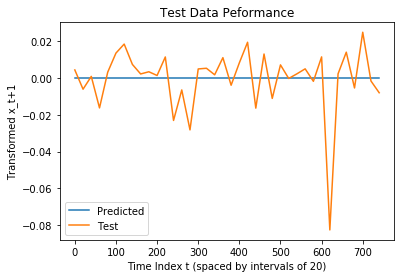

In [18]:
y_pred = ridge.predict(X_test)
plt.plot(range(len(y_pred))[0:-1:20], y_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [19]:
PERFORMANCE_TRACKER.append(("Ridge Regression", ridge_mse))

In [20]:
PERFORMANCE_TRACKER

[('Linear Regression', 0.00024096704709467836),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Ridge Regression', 0.00021136771445694238)]

<b> What's bad, is that Ridge regerssion is barely any better than linear. Moving on. </b> I'm also having a hard time understanding why Ridge has lower MSE when it's just a flat line, why is it a flat line? For now, whatever.

### Attempt Regression 3: Lasso

In [21]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=1000000, normalize=True)
lassocv.fit(scale(X_train), np.ravel(y_train))

lasso = Lasso(max_iter=1000000, normalize=True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), np.ravel(y_train))
y_pred = lasso.predict(scale(X_test))
lasso_mse = mean_squared_error(y_test, y_pred)
print("Lasso MSE: {:.8f}".format(lasso_mse))                          

Lasso MSE: 0.00021137


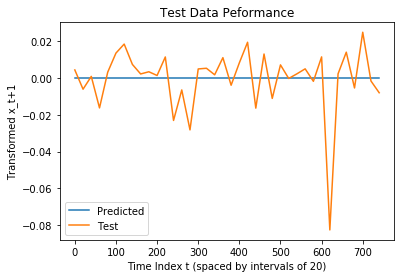

In [22]:
plt.plot(range(len(y_pred))[0:-1:20], y_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [23]:
lasso.coef_

array([-0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,
        0., -0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
        0., -0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,
        0., -0., -0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0., -0.,
        0., -0., -0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,
       -0., -0., -0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
        0., -0., -0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,
       -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0.,
       -0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0.,  0., -0

<b> Ok so now we know why Ridge and Lasso are getting flat lines. They don't like any of the variables. Quite picky! It's interesting that it picks a large enough alpha that this happens. Apparently not predicting is better than predicting. </b> 

In [24]:
PERFORMANCE_TRACKER.append(("Lasso Regression", lasso_mse))

In [25]:
PERFORMANCE_TRACKER

[('Linear Regression', 0.00024096704709467836),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238)]

<b> Alright! We're moving on. </b>

### Attempt Regression 4: PCR

In [26]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X_train))

# Explained Variance
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 4.33,  7.66, 10.91, 14.14, 17.27, 20.36, 23.34, 26.29, 29.21,
       32.  , 34.74, 37.44, 40.06, 42.61, 45.14, 47.51, 49.86, 52.15,
       54.3 , 56.39, 58.4 , 58.91, 59.4 , 59.88, 60.34, 60.8 , 61.25,
       61.69, 62.13, 62.56, 62.99, 63.41, 63.83, 64.25, 64.66, 65.07,
       65.47, 65.86, 66.25, 66.64, 67.03, 67.41, 67.79, 68.17, 68.54,
       68.91, 69.27, 69.63, 69.99, 70.35, 70.7 , 71.05, 71.4 , 71.74,
       72.08, 72.42, 72.75, 73.08, 73.41, 73.73, 74.05, 74.37, 74.69,
       75.01, 75.32, 75.63, 75.94, 76.25, 76.55, 76.85, 77.15, 77.44,
       77.73, 78.02, 78.31, 78.6 , 78.88, 79.16, 79.44, 79.72, 80.  ,
       80.27, 80.54, 80.81, 81.08, 81.35, 81.62, 81.88, 82.14, 82.4 ,
       82.65, 82.9 , 83.15, 83.4 , 83.65, 83.9 , 84.14, 84.38, 84.62,
       84.86, 85.1 , 85.34, 85.57, 85.8 , 86.03, 86.26, 86.49, 86.72,
       86.94, 87.16, 87.38, 87.6 , 87.82, 88.04, 88.25, 88.46, 88.67,
       88.88, 89.09, 89.3 , 89.5 , 89.7 , 89.9 , 90.1 , 90.3 , 90.5 ,
       90.69, 90.88,

(0, 189)

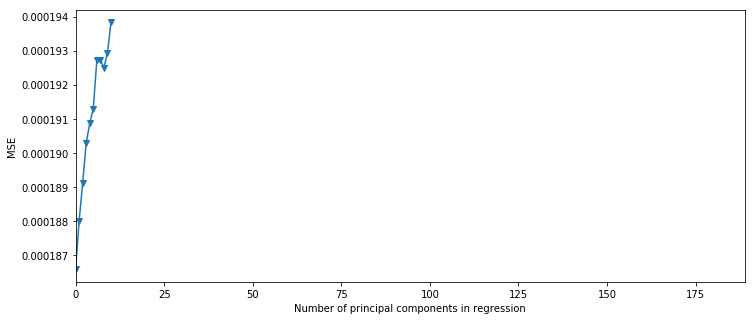

In [27]:
n = len(X_reduced)
pcr_mse = []

pcr = LinearRegression()

# MSE for just intercept (no components)
score = -1 * cross_val_score(pcr, np.ones((n,1)), np.ravel(y_train), cv=10, scoring='neg_mean_squared_error').mean()
pcr_mse.append(score)

# For the rest of the components
for i in range(10):
    score = -1 * cross_val_score(pcr, X_reduced[:, :i+1], np.ravel(y_train), cv=10, scoring='neg_mean_squared_error').mean()
    pcr_mse.append(score)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(pcr_mse, '-v')
ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_xlim([0, len(pca.components_)])

<b> Interesting. Adding components adds MSE right from the start - So don't try predicting it says. Still, let's looking at first few components more closely. </b>

(0, 10)

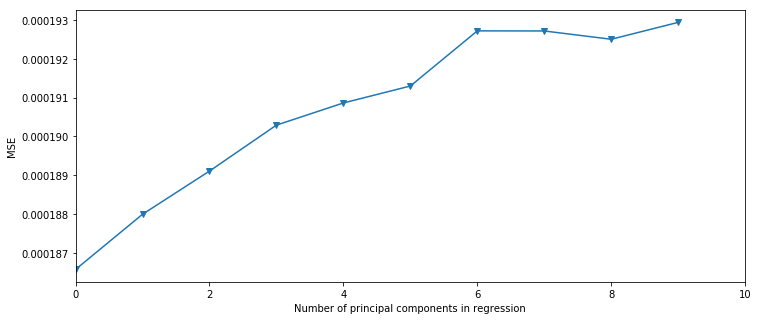

In [28]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(pcr_mse[:10], '-v')
ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_xlim([0, len(pcr_mse[:10])])

In [29]:
pcr_mse[0]  # the intercept of X_reduced

0.0001865717038006667

In [30]:
# so lets just use 1 component...
x_reduced_test = pca.transform(X_test)
x_reduced_test = x_reduced_test[:, :1]

# Train Regression
regr = LinearRegression()
regr.fit(X_reduced[:, :1],  y_train)

# prediction with 1 component1
pca_pred = regr.predict(x_reduced_test)

pca_mse = mean_squared_error(y_test, pca_pred)
print("PCA MSE: {:.8f}".format(pca_mse))

PCA MSE: 0.00021134


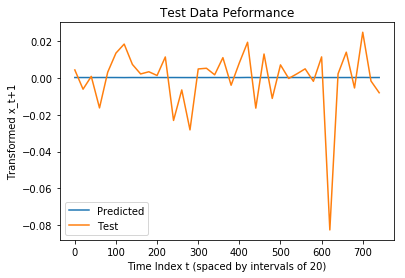

In [31]:
plt.plot(range(len(pca_pred))[0:-1:20], pca_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [32]:
pca_pred[:15]  # the values are very small, but not 0

array([[0.00032807],
       [0.00033124],
       [0.00034028],
       [0.00032901],
       [0.00035111],
       [0.00031983],
       [0.000331  ],
       [0.0003282 ],
       [0.00033759],
       [0.00032788],
       [0.00034697],
       [0.00032911],
       [0.00032317],
       [0.00032103],
       [0.00030948]])

<b> Add to our Performance Tracker </b>

In [33]:
PERFORMANCE_TRACKER.append(("PCR MSE 1 Components", pca_mse))

In [34]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836)]

<b> Small wins are good. PCR with 1 component is outperforming the rest. Still essentially a flat line.</b>

### Attempt Regression 5: Random Forests

In [35]:
depth_mse = np.zeros((10, 3))

for i, num_est in enumerate(range(1, 11)):
    for j, num_depth in enumerate(range(1, 4)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(X_train, np.ravel(y_train))
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(i, j, end='')


0 00 10 21 01 11 22 02 12 23 03 13 24 04 14 25 05 15 26 06 16 27 07 17 28 08 18 29 09 19 2

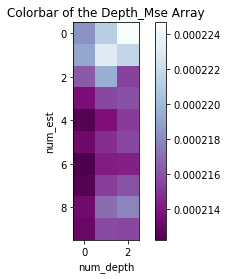

In [36]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [37]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+1, j+1, depth_mse[i, j]))

At num_est: 7 and at num_depth: 1 we have MSE: 0.00021224309606341724


<b> Let's look at the predictions </b>

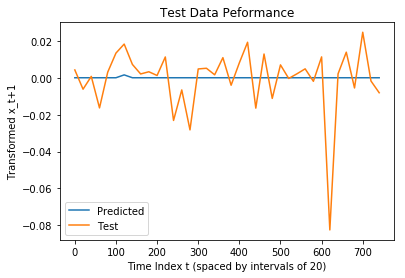

In [38]:
num_est = 7
num_depth = 1

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [39]:
pred[:15]

array([0.00020866, 0.00020866, 0.00020866, 0.00020866, 0.00020866,
       0.00020866, 0.00020866, 0.00020866, 0.00020866, 0.00020866,
       0.00176974, 0.00020866, 0.00020866, 0.00020866, 0.00020866])

In [40]:
PERFORMANCE_TRACKER.append(("Random Forest Regressor", mse))

In [41]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836)]

<b> Let's also try a performance enhanced Random Forest with XGBoost </b>

In [42]:
data_dmatrix = xgb.DMatrix(data=X, label=y)
# DM_X_train, DM_X_test, DM_y_train, DM_y_test = train_test_split(X, y, test_size=)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=4, 
                          gamma=10)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["rmse"]
xg_reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

xgb_pred = xg_reg.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)

[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-rmse:0.49487	validation_1-rmse:0.495316
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	validation_0-rmse:0.48993	validation_1-rmse:0.490376
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	validation_0-rmse:0.485042	validation_1-rmse:0.485488
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	validation_0-rmse:0.4802	validation_1-rmse:0.480646
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[4]	validation_0-rmse:0.475406	validation_1-rmse:0.475852
[22:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[5]	validation_0-rmse:0.47066	validation_1-rmse:

In [43]:
print("XGB MSE: {:.8f}".format(xgb_mse))
PERFORMANCE_TRACKER.append(("XGB MSE", xgb_mse))

XGB MSE: 0.00021155


In [44]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB MSE', 0.00021155428751752842),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836)]

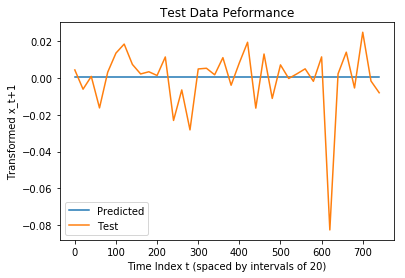

In [45]:
plt.plot(range(len(xgb_pred))[0:-1:20], xgb_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

<b> Now with grid search to find better possible parameters (not hopeful for anything different) </b>

In [46]:
# A parameter grid for XGBoost
xgb = xgb.XGBRegressor(nthread=-1)

params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,5)],  
          'subsample':[i/10.0 for i in range(6,8)],
          'colsample_bytree':[i/10.0 for i in range(6,8)], 
          'max_depth': [3,4]}

grid = GridSearchCV(xgb, params, verbose=10)
grid.fit(X_train, y_train)

xgb_pred = grid.best_estimator_.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)

C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6, score=-0.002481187117548078, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6, score=-1.2920744052458133e-06, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.6, score=-0.0020516334709768103, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7, score=-0.0021543978104430206, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7, score=-1.9482457367159256e-05, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=4, subsample=0.7, score=-0.0018688008665281863, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.6s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6, score=-0.002481187117548078, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.3s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6, score=-1.2920744052458133e-06, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.6, score=-0.0020516334709768103, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.9s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.0021543978104430206, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7, score=-1.9482457367159256e-05, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=3, min_child_weight=5, subsample=0.7, score=-0.0018688008665281863, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=4, min_child_weight=4, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=4, min_child_weight=4, subsample=0.6, score=-0.002481187117548078, total=   0.9s
[CV] colsample_bytree=0.6, gamma=0.3, max_depth=4, min_child_weight=4, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.3, max_depth=4, min_child_weight=4, subsample=0.6, score=-1.2920744052458133e-06, total=   0.9s


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.5min finished


In [47]:
print("XGB Grid Searched MSE: {:.8f}".format(xgb_mse))
PERFORMANCE_TRACKER.append(("XGB Grid Searched MSE", xgb_mse))

XGB Grid Searched MSE: 0.00021142


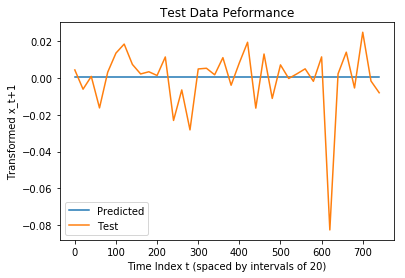

In [48]:
plt.plot(range(len(xgb_pred))[0:-1:20], xgb_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [49]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('XGB MSE', 0.00021155428751752842),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836)]

<b> So XGBoost doesn't help. Tuning parameters is unlikely to help. So far PCR with the first component is best. Random Forest does worse than Ridge/Lasso, and Linear Regression is saddest. I will try SVMs next though I don't hope for much. When I started I hypothesized SVM or Random Forests would be the best for this task. I still believe that but most likely I need to approach the data from a much different perspective. E.g. Focusing on some companies, not all.</b>

### Attempt Regression 6: Support Vector Machines

In [50]:
svm = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

svm.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1.0, 10.0, 100.0, 1000.0], 'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
svm_pred = svm.best_estimator_.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_pred)

In [52]:
print("SVM MSE: {:.8f}".format(svm_mse))


SVM MSE: 0.00041312


In [53]:
PERFORMANCE_TRACKER.append(("SVM MSE", svm_mse))
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('XGB MSE', 0.00021155428751752842),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433)]

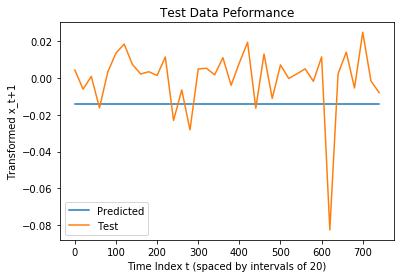

In [54]:
plt.plot(range(len(svm_pred))[0:-1:20], svm_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

# Change up the approach to the Data...

<b> 
1. Let's split all the companies into different arrays. Then find the ones with the most correlation. Keep those maybe? 
    
2. Or only look at company 4 and ignore the others.

3. Or take all the windowed data, so each company * number of windows, train on that. 

4. If top 3 don't help. We'll see.
</b>

In [55]:
X.head()

comp1_xt  comp1_xt-1  comp1_xt-2  comp1_xt-3  comp1_xt-4  comp1_xt-5  \
0 -0.049917   -0.015821   -0.014748   -0.020682    0.020328   -0.033654   
1  0.026143   -0.049917   -0.015821   -0.014748   -0.020682    0.020328   
2  0.045449    0.026143   -0.049917   -0.015821   -0.014748   -0.020682   
3  0.027492    0.045449    0.026143   -0.049917   -0.015821   -0.014748   
4 -0.026302    0.027492    0.045449    0.026143   -0.049917   -0.015821   

   comp1_xt-6  comp1_xt-7  comp1_xt-8  comp1_xt-9     ...       comp9_xt-11  \
0   -0.015738   -0.000337    0.012430   -0.007476     ...         -0.001938   
1   -0.033654   -0.015738   -0.000337    0.012430     ...          0.002906   
2    0.020328   -0.033654   -0.015738   -0.000337     ...          0.009625   
3   -0.020682    0.020328   -0.033654   -0.015738     ...         -0.007210   
4   -0.014748   -0.020682    0.020328   -0.033654     ...          0.012464   

   comp9_xt-12  comp9_xt-13  comp9_xt-14  comp9_xt-15  comp9_xt-16  \
0    -0.016799    -0.006168    -0.003306     0.005674    -0.010847   
1    -0.001938    -0.016799    -0.006168    -0.003306     0.005674   
2     0.002906    -0.001938    -0.016799    -0.006168    -0.003306   
3     0.009625     0.002906    -0.001938    -0.016799    -0.006168   
4    -0.007210     0.009625     0.002906    -0.001938    -0.016799   

   comp9_xt-17  comp9_xt-18  comp9_xt-19  comp9_xt-20  
0     0.003759     0.001413     0.014245    -0.026429  
1    -0.010847     0.003759     0.001413     0.014245  
2     0.005674    -0.010847     0.003759     0.001413  
3    -0.003306     0.005674    -0.010847     0.003759  
4    -0.006168    -0.003306     0.005674    -0.010847  

[5 rows x 189 columns]

In [56]:
y.head()

comp4_xt+1
0    0.008376
1   -0.001133
2    0.001854
3    0.000720
4    0.003592

In [57]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]

companies

{'comp1': array(['comp1_xt', 'comp1_xt-1', 'comp1_xt-2', 'comp1_xt-3', 'comp1_xt-4',
        'comp1_xt-5', 'comp1_xt-6', 'comp1_xt-7', 'comp1_xt-8',
        'comp1_xt-9', 'comp1_xt-10', 'comp1_xt-11', 'comp1_xt-12',
        'comp1_xt-13', 'comp1_xt-14', 'comp1_xt-15', 'comp1_xt-16',
        'comp1_xt-17', 'comp1_xt-18', 'comp1_xt-19', 'comp1_xt-20'],
       dtype=object),
 'comp2': array(['comp2_xt', 'comp2_xt-1', 'comp2_xt-2', 'comp2_xt-3', 'comp2_xt-4',
        'comp2_xt-5', 'comp2_xt-6', 'comp2_xt-7', 'comp2_xt-8',
        'comp2_xt-9', 'comp2_xt-10', 'comp2_xt-11', 'comp2_xt-12',
        'comp2_xt-13', 'comp2_xt-14', 'comp2_xt-15', 'comp2_xt-16',
        'comp2_xt-17', 'comp2_xt-18', 'comp2_xt-19', 'comp2_xt-20'],
       dtype=object),
 'comp3': array(['comp3_xt', 'comp3_xt-1', 'comp3_xt-2', 'comp3_xt-3', 'comp3_xt-4',
        'comp3_xt-5', 'comp3_xt-6', 'comp3_xt-7', 'comp3_xt-8',
        'comp3_xt-9', 'comp3_xt-10', 'comp3_xt-11', 'comp3_xt-12',
        'comp3_xt-13', 'comp3_xt-1

In [58]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [59]:
companyFour = companyData[3]
companyFour

comp4_xt  comp4_xt-1  comp4_xt-2  comp4_xt-3  comp4_xt-4  comp4_xt-5  \
0     0.013591   -0.007864   -0.000313   -0.003335    0.010460    0.001579   
1     0.008376    0.013591   -0.007864   -0.000313   -0.003335    0.010460   
2    -0.001133    0.008376    0.013591   -0.007864   -0.000313   -0.003335   
3     0.001854   -0.001133    0.008376    0.013591   -0.007864   -0.000313   
4     0.000720    0.001854   -0.001133    0.008376    0.013591   -0.007864   
5     0.003592    0.000720    0.001854   -0.001133    0.008376    0.013591   
6     0.009179    0.003592    0.000720    0.001854   -0.001133    0.008376   
7     0.005871    0.009179    0.003592    0.000720    0.001854   -0.001133   
8    -0.005871    0.005871    0.009179    0.003592    0.000720    0.001854   
9     0.005063   -0.005871    0.005871    0.009179    0.003592    0.000720   
10   -0.000101    0.005063   -0.005871    0.005871    0.009179    0.003592   
11    0.004133   -0.000101    0.005063   -0.005871    0.005871    0.009179   
12    0.012894    0.004133   -0.000101    0.005063   -0.005871    0.005871   
13   -0.008878    0.012894    0.004133   -0.000101    0.005063   -0.005871   
14   -0.049291   -0.008878    0.012894    0.004133   -0.000101    0.005063   
15    0.014837   -0.049291   -0.008878    0.012894    0.004133   -0.000101   
16    0.005069    0.014837   -0.049291   -0.008878    0.012894    0.004133   
17    0.001753    0.005069    0.014837   -0.049291   -0.008878    0.012894   
18    0.001441    0.001753    0.005069    0.014837   -0.049291   -0.008878   
19    0.003081    0.001441    0.001753    0.005069    0.014837   -0.049291   
20    0.001844    0.003081    0.001441    0.001753    0.005069    0.014837   
21    0.008865    0.001844    0.003081    0.001441    0.001753    0.005069   
22    0.002331    0.008865    0.001844    0.003081    0.001441    0.001753   
23    0.001719    0.002331    0.008865    0.001844    0.003081    0.001441   
24    0.001313    0.001719    0.002331    0.008865    0.001844    0.003081   
25    0.000706    0.001313    0.001719    0.002331    0.008865    0.001844   
26    0.008335    0.000706    0.001313    0.001719    0.002331    0.008865   
27   -0.002002    0.008335    0.000706    0.001313    0.001719    0.002331   
28   -0.009059   -0.002002    0.008335    0.000706    0.001313    0.001719   
29    0.006249   -0.009059   -0.002002    0.008335    0.000706    0.001313   
...        ...         ...         ...         ...         ...         ...   
2471  0.000066    0.008298   -0.029102   -0.000130    0.004997   -0.008229   
2472 -0.004638    0.000066    0.008298   -0.029102   -0.000130    0.004997   
2473 -0.001196   -0.004638    0.000066    0.008298   -0.029102   -0.000130   
2474  0.001130   -0.001196   -0.004638    0.000066    0.008298   -0.029102   
2475  0.000929    0.001130   -0.001196   -0.004638    0.000066    0.008298   
2476  0.013903    0.000929    0.001130   -0.001196   -0.004638    0.000066   
2477  0.008016    0.013903    0.000929    0.001130   -0.001196   -0.004638   
2478 -0.008409    0.008016    0.013903    0.000929    0.001130   -0.001196   
2479  0.004833   -0.008409    0.008016    0.013903    0.000929    0.001130   
2480 -0.006667    0.004833   -0.008409    0.008016    0.013903    0.000929   
2481  0.000197   -0.006667    0.004833   -0.008409    0.008016    0.013903   
2482 -0.000722    0.000197   -0.006667    0.004833   -0.008409    0.008016   
2483  0.010379   -0.000722    0.000197   -0.006667    0.004833   -0.008409   
2484  0.003695    0.010379   -0.000722    0.000197   -0.006667    0.004833   
2485 -0.010406    0.003695    0.010379   -0.000722    0.000197   -0.006667   
2486  0.030264   -0.010406    0.003695    0.010379   -0.000722    0.000197   
2487  0.014545    0.030264   -0.010406    0.003695    0.010379   -0.000722   
2488  0.007970    0.014545    0.030264   -0.010406    0.003695    0.010379   
2489 -0.017706    0.007970    0.014545    0.030264   -0.010406    0.003695   
2490  0.000253   -0.017706  

### Just looking at Company 4 to try to predict future

In [106]:
depth_mse = np.zeros((49, 2))

for i, num_est in enumerate(range(1, 50)):
    for j, num_depth in enumerate(range(1, 3)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(companyFour[:1750], np.ravel(y_train))
        pred = regr.predict(companyFour[1750:])
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(num_est, num_depth, " ", end='')


1 1  1 2  1 3  2 1  2 2  2 3  3 1  3 2  3 3  4 1  4 2  4 3  5 1  5 2  5 3  6 1  6 2  6 3  7 1  7 2  7 3  8 1  8 2  8 3  9 1  9 2  9 3  10 1  10 2  10 3  11 1  11 2  11 3  12 1  12 2  12 3  13 1  13 2  13 3  14 1  14 2  14 3  15 1  15 2  15 3  16 1  16 2  16 3  17 1  17 2  17 3  18 1  18 2  18 3  19 1  19 2  19 3  20 1  20 2  20 3  21 1  21 2  21 3  22 1  22 2  22 3  23 1  23 2  23 3  24 1  24 2  24 3  25 1  25 2  25 3  26 1  26 2  26 3  27 1  27 2  27 3  28 1  28 2  28 3  29 1  29 2  29 3  30 1  30 2  30 3  31 1  31 2  31 3  32 1  32 2  32 3  33 1  33 2  33 3  34 1  34 2  34 3  35 1  35 2  35 3  36 1  36 2  36 3  37 1  37 2  37 3  38 1  38 2  38 3  39 1  39 2  39 3  40 1  40 2  40 3  41 1  41 2  41 3  42 1  42 2  42 3  43 1  43 2  43 3  44 1  44 2  44 3  45 1  45 2  45 3  46 1  46 2  46 3  47 1  47 2  47 3  48 1  48 2  48 3  49 1  49 2  49 3  50 1  50 2  50 3  51 1  51 2  51 3  52 1  52 2  52 3  53 1  53 2  53 3  54 1  54 2  54 3  55 1  55 2  55 3  56 1  56 2  56 3  57 1  57 2  57 3  5

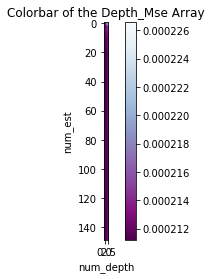

In [107]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [108]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+1, j+1, depth_mse[i, j]))

At num_est: 41 and at num_depth: 1 we have MSE: 0.00021120335259503415


<b> Let's look at the predictions </b>

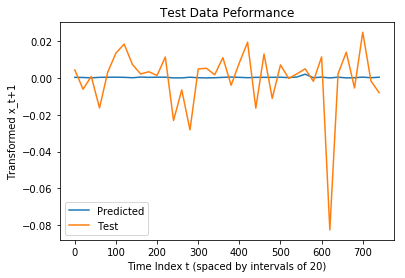

In [109]:
num_est = 41
num_depth = 1

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(companyFour[:1750], np.ravel(y_train))
pred = regr.predict(companyFour[1750:])
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [110]:
print("Company 4 Only RandomForest MSE: {:.8f}".format(mse))

Company 4 Only RandomForest MSE: 0.00021120


In [111]:
PERFORMANCE_TRACKER.append(("Company 4 Only RandomForest MSE", mse))

In [112]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433)]

### Company 4 SVM?

In [113]:
svm = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

svm.fit(companyFour[:1750], np.ravel(y_train))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1.0, 10.0, 100.0, 1000.0], 'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [114]:
svm_pred = svm.best_estimator_.predict(companyFour[1750:])
svm_mse = mean_squared_error(y_test, svm_pred)

In [115]:
print("SVM MSE: {:.8f}".format(svm_mse))

SVM MSE: 0.00041312


In [116]:
PERFORMANCE_TRACKER.append(("SVM Company 4 MSE", svm_mse))

In [117]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433)]

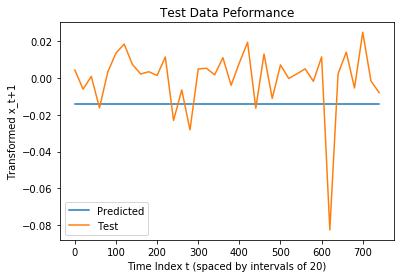

In [118]:
plt.plot(range(len(svm_pred))[0:-1:20], svm_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

### :(

### Go to attempt 2 in new approach. Let's find other companies that help the prediction.

In [119]:
from scipy.stats.stats import pearsonr

In [120]:
for i in range(9):
    corrcoeff, pvalue = pearsonr(companyData[3]['comp4_xt'], companyData[i]['comp{}_xt'.format(i+1)])
    print("The correlation coefficient with company 4 and company {} is: {} with a p-value of: {}".format(i+1, corrcoeff, pvalue))
    print()

The correlation coefficient with company 4 and company 1 is: 0.5073380970940654 with a p-value of: 1.0266120994452795e-163

The correlation coefficient with company 4 and company 2 is: 0.49503290981280357 with a p-value of: 9.144796929266883e-155

The correlation coefficient with company 4 and company 3 is: 0.5790028032144008 with a p-value of: 7.182729342146924e-224

The correlation coefficient with company 4 and company 4 is: 1.0 with a p-value of: 0.0

The correlation coefficient with company 4 and company 5 is: 0.5298346776479866 with a p-value of: 4.6649895437150074e-181

The correlation coefficient with company 4 and company 6 is: 0.4773442747553691 with a p-value of: 1.5904811130065473e-142

The correlation coefficient with company 4 and company 7 is: 0.5776051856346299 with a p-value of: 1.4972920536845594e-222

The correlation coefficient with company 4 and company 8 is: 0.4700650101393953 with a p-value of: 1.0799068436759994e-137

The correlation coefficient with company 4 a

<b> Company 3, 7, and 9 seem to be useful </b>

In [154]:
three_companies = pd.concat([companyData[3], companyData[2], companyData[6], companyData[8]], axis=1)
three_companies.head()

comp4_xt  comp4_xt-1  comp4_xt-2  comp4_xt-3  comp4_xt-4  comp4_xt-5  \
0  0.013591   -0.007864   -0.000313   -0.003335    0.010460    0.001579   
1  0.008376    0.013591   -0.007864   -0.000313   -0.003335    0.010460   
2 -0.001133    0.008376    0.013591   -0.007864   -0.000313   -0.003335   
3  0.001854   -0.001133    0.008376    0.013591   -0.007864   -0.000313   
4  0.000720    0.001854   -0.001133    0.008376    0.013591   -0.007864   

   comp4_xt-6  comp4_xt-7  comp4_xt-8  comp4_xt-9     ...       comp9_xt-11  \
0   -0.006927    0.006716    0.002003    0.012528     ...         -0.001938   
1    0.001579   -0.006927    0.006716    0.002003     ...          0.002906   
2    0.010460    0.001579   -0.006927    0.006716     ...          0.009625   
3   -0.003335    0.010460    0.001579   -0.006927     ...         -0.007210   
4   -0.000313   -0.003335    0.010460    0.001579     ...          0.012464   

   comp9_xt-12  comp9_xt-13  comp9_xt-14  comp9_xt-15  comp9_xt-16  \
0    -0.016799    -0.006168    -0.003306     0.005674    -0.010847   
1    -0.001938    -0.016799    -0.006168    -0.003306     0.005674   
2     0.002906    -0.001938    -0.016799    -0.006168    -0.003306   
3     0.009625     0.002906    -0.001938    -0.016799    -0.006168   
4    -0.007210     0.009625     0.002906    -0.001938    -0.016799   

   comp9_xt-17  comp9_xt-18  comp9_xt-19  comp9_xt-20  
0     0.003759     0.001413     0.014245    -0.026429  
1    -0.010847     0.003759     0.001413     0.014245  
2     0.005674    -0.010847     0.003759     0.001413  
3    -0.003306     0.005674    -0.010847     0.003759  
4    -0.006168    -0.003306     0.005674    -0.010847  

[5 rows x 84 columns]

In [155]:
depth_mse = np.zeros((10, 9))

for i, num_est in enumerate(range(1, 11)):
    for j, num_depth in enumerate(range(1, 10)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(three_companies[:1750], np.ravel(y_train))
        pred = regr.predict(three_companies[1750:])
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(i, j, " ", end='')


0 0  0 1  0 2  0 3  0 4  0 5  0 6  0 7  0 8  1 0  1 1  1 2  1 3  1 4  1 5  1 6  1 7  1 8  2 0  2 1  2 2  2 3  2 4  2 5  2 6  2 7  2 8  3 0  3 1  3 2  3 3  3 4  3 5  3 6  3 7  3 8  4 0  4 1  4 2  4 3  4 4  4 5  4 6  4 7  4 8  5 0  5 1  5 2  5 3  5 4  5 5  5 6  5 7  5 8  6 0  6 1  6 2  6 3  6 4  6 5  6 6  6 7  6 8  7 0  7 1  7 2  7 3  7 4  7 5  7 6  7 7  7 8  8 0  8 1  8 2  8 3  8 4  8 5  8 6  8 7  8 8  9 0  9 1  9 2  9 3  9 4  9 5  9 6  9 7  9 8  

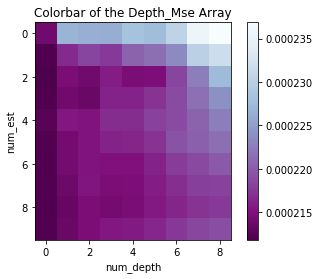

In [156]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [157]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+1, j+1, depth_mse[i, j]))

At num_est: 3 and at num_depth: 1 we have MSE: 0.00021179332960318225


<b> Let's look at the predictions </b>

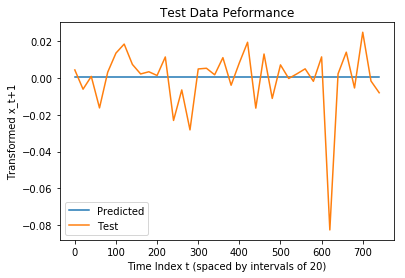

In [158]:
num_est = 3
num_depth = 1

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(three_companies[:1750], np.ravel(y_train))
pred = regr.predict(three_companies[1750:])
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [159]:
print("three_companies Only RandomForest MSE: {:.8f}".format(mse))

three_companies Only RandomForest MSE: 0.00021179


In [160]:
PERFORMANCE_TRACKER.append(("three_companies Only RandomForest MSE", mse))

In [161]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433),
 ('SVM three_companies MSE', 0.0004131245303642433)]

### Three Companies SVM?

In [162]:
# Set the parameters by cross-validation
param_grid = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}

svm = GridSearchCV(SVR(kernel='rbf'), cv=5, param_grid=param_grid)

svm.fit(three_companies[:1750], np.ravel(y_train))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [163]:
svm_pred = svm.best_estimator_.predict(three_companies[1750:])
svm_mse = mean_squared_error(y_test, svm_pred)

In [164]:
print("SVM MSE: {:.8f}".format(svm_mse))

SVM MSE: 0.00041312


In [165]:
PERFORMANCE_TRACKER.append(("SVM three_companies MSE", svm_mse))

In [169]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433),
 ('SVM three_companies MSE', 0.0004131245303642433)]

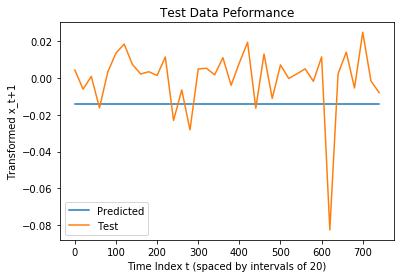

In [167]:
plt.plot(range(len(svm_pred))[0:-1:20], svm_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

### So Three Companies (+ itself) and Company 4 itself Random Forest work better than all the rest. 

### Maybe lets try XGBoost on it too (FINDING THE BEST PARAMS as well)

In [209]:
import xgboost as xgb
dtrain = xgb.DMatrix(three_companies[:1750], label=y_train)
dtest = xgb.DMatrix(three_companies[1750:], label=y_test)

num_boost_round = 999

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric': "mae"
}

# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,12)
    for min_child_weight in range(1,10)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))


CV with max_depth=1, min_child_weight=1
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 ex

C:\Users\Abdurrahman\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

In [210]:
# Ok update according to best params
params['max_depth'] = 1
params['min_child_weight'] = 6

In [192]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [193]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra

C:\Users\Abdurrahman\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

In [194]:
# update params again
params['subsample'] = 1
params['colsample_bytree'] = 1

In [199]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned node

C:\Users\Abdurrahman\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[23:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, 

In [200]:
# update accordingly
params['eta'] = .01

In [203]:
#results
params['eval_metric'] = "rmse"

In [211]:
# train a model with this now
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	Test-mae:0.350277
Will train until Test-mae hasn't improved in 10 rounds.
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	Test-mae:0.24538
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	Test-mae:0.171934
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	Test-mae:0.120509
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[4]	Test-mae:0.084503
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[5]	Test-mae:0.059329
[23:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[6]	Test-mae:0.041724
[23:39:49] src

In [212]:
XGB_MSE = 0.01491**2
print("XGB best params MSE is: ", XGB_MSE)

XGB best params MSE is:  0.00022230809999999998


In [213]:
print("XGB three_companies Best Param MSE: {:.8f}".format(XGB_MSE))
PERFORMANCE_TRACKER.append(("XGB three_companies Best Param MSE", XGB_MSE))

XGB three_companies Best Param MSE: 0.00022231


In [216]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('XGB three_companies Grid Searched MSE', 0.0002112955900629867),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('XGB three_companies Best Param MSE', 0.00022230809999999998),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433),
 ('SVM three_companies MSE', 0.0004131245303642433)]

### Seems I didn't use XGBoost well as it didn't outperform...

### So there was one last attempt, I had it as my new attempt 3: take all the windowed data, so each company * number of windows, train on that. Basically we are training a model that acts as if all the stock data is the same and it points to that y label...then we try to predict the y label...

In [225]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [227]:
all_data.shape

(22509, 21)

In [229]:
all_y.shape

(22509, 1)

### shuffle them since we are just assuming that a specific company value is not important for prediction

In [230]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

#### Fit our best model so far. The Random Forest.

In [261]:
depth_mse = np.zeros((2, 6))

for i, num_est in enumerate(range(19, 21)):
    for j, num_depth in enumerate(range(24, 30)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(X_train, np.ravel(y_train))
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(num_est, num_depth, " ", end='')


19 24  19 25  19 26  19 27  19 28  19 29  20 24  20 25  20 26  20 27  20 28  20 29  

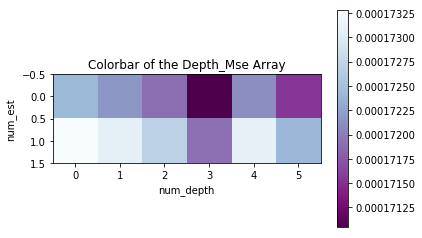

In [262]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [263]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+19, j+24, depth_mse[i, j]))

At num_est: 19 and at num_depth: 27 we have MSE: 0.00017104623003162334


<b> Let's look at the predictions </b>

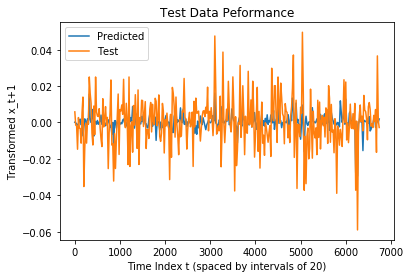

In [264]:
num_est = 19
num_depth = 27

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [265]:
print("All Data Merged RandomForest MSE: {:.8f}".format(mse))

All Data Merged RandomForest MSE: 0.00017105


In [268]:
PERFORMANCE_TRACKER.append(("All Data Merged RandomForest MSE", mse))

In [269]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('All Data Merged RandomForest MSE', 0.00017104623003162334),
 ('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('XGB three_companies Grid Searched MSE', 0.0002112955900629867),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('XGB three_companies Best Param MSE', 0.00022230809999999998),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.0004131245303642433),
 ('SVM three_companies MSE', 0.0004131245303642433)]

### Nice! We got some good improvement.
### Now let's try with the 3 companies (3, 7, 9) + company 4, and see if that gives us anything better.

In [270]:
all_data = companyData[2]  # company 3
all_data.columns = list(range(21))
all_y = y

for each_comp in [companyData[3], companyData[6], companyData[8]]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [271]:
all_data.shape

(10004, 21)

In [272]:
all_y.shape

(10004, 1)

### shuffle them since we are just assuming that a specific company value is not important for prediction

In [273]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

#### Fit our best model so far. The Random Forest.

In [278]:
depth_mse = np.zeros((6, 6))

for i, num_est in enumerate(range(19, 25)):
    for j, num_depth in enumerate(range(24, 30)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(X_train, np.ravel(y_train))
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(num_est, num_depth, " ", end='')


19 24  19 25  19 26  19 27  19 28  19 29  20 24  20 25  20 26  20 27  20 28  20 29  21 24  21 25  21 26  21 27  21 28  21 29  22 24  22 25  22 26  22 27  22 28  22 29  23 24  23 25  23 26  23 27  23 28  23 29  24 24  24 25  24 26  24 27  24 28  24 29  

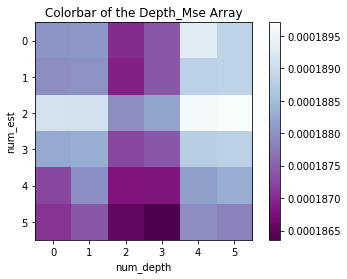

In [279]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [280]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+19, j+24, depth_mse[i, j]))

At num_est: 24 and at num_depth: 27 we have MSE: 0.00018635719763550798


<b> Let's look at the predictions </b>

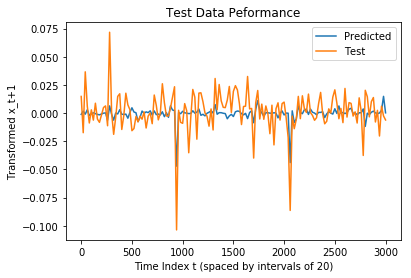

In [281]:
num_est = 24
num_depth = 27

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [283]:
print("3 Companies Data Merged RandomForest MSE: {:.8f}".format(mse))

3 Companies Data Merged RandomForest MSE: 0.00018636


In [284]:
PERFORMANCE_TRACKER.append(("3 Companies (+ company 4) Data Merged RandomForest MSE", mse))

In [285]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('All Data Merged RandomForest MSE', 0.00017104623003162334),
 ('3 Companies (+ company 4) Data Merged RandomForest MSE',
  0.00018635719763550798),
 ('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('XGB three_companies Grid Searched MSE', 0.0002112955900629867),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('XGB three_companies Best Param MSE', 0.00022230809999999998),
 ('Linear Regression', 0.00024096704709467836),
 ('SVM MSE', 0.0004131245303642433),
 ('SVM Company 4 MSE', 0.00041

### Using all the companies proves much better. For the final attempt, let's try a random selection of companies... 

In [286]:
all_data = companyData[3]  # company 3
all_data.columns = list(range(21))
all_y = y

for each_comp in [companyData[1], companyData[5], companyData[4], companyData[7]]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [287]:
all_data.shape

(12505, 21)

In [288]:
all_y.shape

(12505, 1)

### shuffle them since we are just assuming that a specific company value is not important for prediction

In [289]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

#### Fit our best model so far. The Random Forest.

In [296]:
depth_mse = np.zeros((1, 6))

for i, num_est in enumerate(range(21, 22)):
    for j, num_depth in enumerate(range(20, 26)):
        regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(X_train, np.ravel(y_train))
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(num_est, num_depth, " ", end='')


21 20  21 21  21 22  21 23  21 24  21 25  

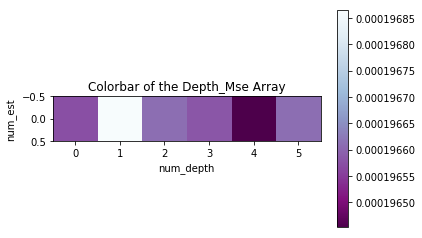

In [297]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [298]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+21, j+20, depth_mse[i, j]))

At num_est: 21 and at num_depth: 24 we have MSE: 0.00019645233066255236


<b> Let's look at the predictions </b>

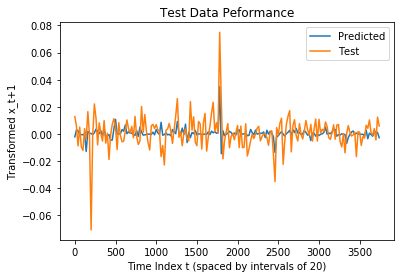

In [299]:
num_est = 21
num_depth = 24

regr = RandomForestRegressor(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [300]:
print("Random Selection Data Merged RandomForest MSE: {:.8f}".format(mse))

Random Selection Data Merged RandomForest MSE: 0.00019645


In [301]:
PERFORMANCE_TRACKER.append(("Random Selection Data Merged RandomForest MSE", mse))

In [302]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('All Data Merged RandomForest MSE', 0.00017104623003162334),
 ('3 Companies (+ company 4) Data Merged RandomForest MSE',
  0.00018635719763550798),
 ('Random Selection Data Merged RandomForest MSE', 0.00019645233066255236),
 ('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('XGB three_companies Grid Searched MSE', 0.0002112955900629867),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('XGB three_companies Best Param MSE', 0.00022230809999999998),
 ('Linear Regression', 0.00024096704709

### Ok, we've determined that all the data is best. Let's quickly do a SVM to see if it does anything.

# SVM with all Data Merged

In [373]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [374]:
all_data.shape

(22509, 21)

In [375]:
all_y.shape

(22509, 1)

### shuffle them since we are just assuming that a specific company value is not important for prediction

In [376]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

In [377]:
n_samples, n_features = 10, 5
np.random.seed(0)
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train,y_train)
clf.best_params_

C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

{'C': 1.5, 'epsilon': 0.5, 'gamma': 1e-07, 'kernel': 'linear'}

In [378]:
svm = SVR(kernel= 'linear', C= 1.5, epsilon=0.5, gamma= 1e-07)

svm.fit(X_train, np.ravel(y_train))

SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma=1e-07,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [379]:
# svm_pred = svm.best_estimator_.predict(X_test)
svm_pred = svm.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_pred)

In [380]:
print("SVM All Data Merged MSE: {:.8f}".format(svm_mse))


SVM All Data Merged MSE: 0.00039655


In [ ]:
PERFORMANCE_TRACKER.append(("SVM All Data Merged MSE", svm_mse))

In [385]:
PERFORMANCE_TRACKER.sort(key = lambda x: x[1])
PERFORMANCE_TRACKER

[('All Data Merged RandomForest MSE', 0.00017104623003162334),
 ('3 Companies (+ company 4) Data Merged RandomForest MSE',
  0.00018635719763550798),
 ('Random Selection Data Merged RandomForest MSE', 0.00019645233066255236),
 ('three_companies Only RandomForest MSE', 0.00021051009812112767),
 ('Company 4 Only RandomForest MSE', 0.00021120335259503415),
 ('XGB three_companies Grid Searched MSE', 0.0002112955900629867),
 ('PCR MSE 1 Components', 0.00021133907860528155),
 ('Ridge Regression', 0.00021136771445694238),
 ('Lasso Regression', 0.00021136771445694238),
 ('XGB Grid Searched MSE', 0.00021141764822719188),
 ('Company 4 Only RandomForest MSE', 0.00021154470600474968),
 ('XGB MSE', 0.00021155428751752842),
 ('three_companies Only RandomForest MSE', 0.00021179332960318225),
 ('Random Forest Regressor', 0.00021224309606341724),
 ('Linear Regression KFOLD', 0.00021755499959386784),
 ('XGB three_companies Best Param MSE', 0.00022230809999999998),
 ('Linear Regression', 0.00024096704709

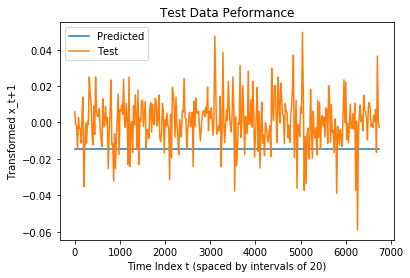

In [382]:
plt.plot(range(len(svm_pred))[0:-1:20], svm_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

### SVM is proving to be very bad, it's probably something on my side. I don't think SVMs should be this bad.

# So the Random Forest Model on all the data merged is best. Let's now fine tune it.

<b> Let's look at the predictions </b>

In [2]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [3]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]


In [4]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [5]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [6]:
all_data.shape

(22509, 21)

In [7]:
all_y.shape

(22509, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

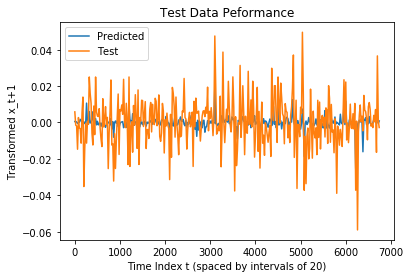

In [67]:
# These are the params I found that worked best for the classification
params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

regr = RandomForestRegressor(**params, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [68]:
print("(BEST PARAMS USED FROM LOGISTIC) All Data Merged RandomForest MSE: {:.8f}".format(mse))

(BEST PARAMS USED FROM LOGISTIC) All Data Merged RandomForest MSE: 0.00016371


<b> Hey, look at that! Using the best params we got from our Random Classifier we got the MSE: 0.00016371. Previous best for regression was: 0.00017104623.
</b>

In [69]:
0.00016371 / 0.00017104623

0.9571096656149626

In [73]:
import pickle
# # Commented out after saving...
# with open('./RegressionModel', 'wb') as f:
#     pickle.dump(regr, f)

In [74]:
# in your prediction file
with open('./RegressionModel', 'rb') as f:
    rf = pickle.load(f)

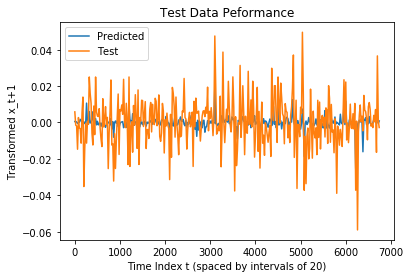

In [75]:
pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [76]:
mse

0.00016371034525098068

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Final Results:
#### Without Randomized Search: All Data Merged Random Forest -  MSE: 0.00017104623003162334; num_est = 19, num_depth = 27

#### With Randomized Search Parameters: All Data Merged RandomForest MSE: 0.00016371

Parameters are: 
params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### To be thorough I did a Randomized Search for Regression specficially and found these parameters. However, it was extremely slow so it's only using 1000 data points instead of 22k original data. I will test if these give better values than the params we found for the Classification Forest.

In [ ]:
# These are params I found in a different randomized search for regression
# However it was really slow so I did a search with only 1000 data points, so
# I am not 100% convinced by it immediately. I will test it.

# params = {'bootstrap': True,
#  'max_depth': 5,
#  'max_features': 'auto',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 1500}

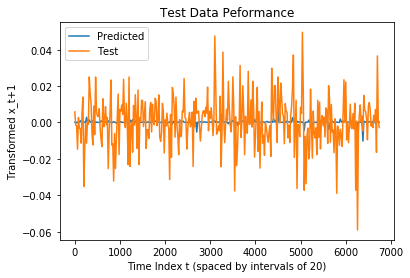

In [49]:

params = {'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1500}

regr = RandomForestRegressor(**params, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [51]:
print("(BEST PARAMS USED FROM 1000 Data Points Regression Search) All Data Merged RandomForest MSE: {:.8f}".format(mse))

(BEST PARAMS USED FROM 1000 Data Points Regression Search) All Data Merged RandomForest MSE: 0.00018410


This value is larger then the MSE we get using the Classification forest <b> (0.00016371) </b> parameters. So we will keep those parameters moving forward. If we had enough processing power we would ideally check a RandomizedSearch on the Regression Forest but it was taking insanely long. (16 minutes for 4 predictions, when you want to test 300 predictions...) 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# SAVE THE REGRESSION MODEL

In [10]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [11]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]


In [12]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [13]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [14]:
all_data.shape

(22509, 21)

In [15]:
all_y.shape

(22509, 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0, random_state=42, shuffle=True)

In [17]:

params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

regr = RandomForestRegressor(**params, random_state=2)
regr.fit(X_train, np.ravel(y_train))


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [18]:
# import pickle
# # Commented out after saving...
# with open('./RegressionModel', 'wb') as f:
#     pickle.dump(regr, f)

# Test the Saved Model

In [19]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [20]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]


In [21]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [22]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])

In [23]:
all_data.shape

(22509, 21)

In [24]:
all_y.shape

(22509, 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

In [26]:
# in your prediction file
with open('./RegressionModel', 'rb') as f:
    rf = pickle.load(f)

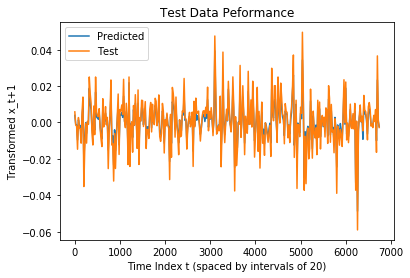

In [27]:
pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

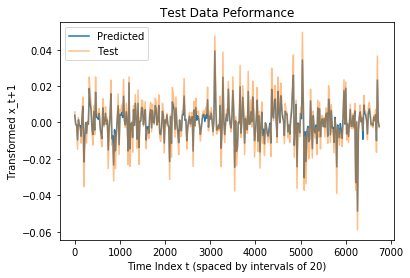

In [28]:
plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test", alpha=0.5)
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Part 3: Explore Various Classification Models and Find the Best to Predict  $x_{t+1} >= 0$

## Part 1: Load Data

In [65]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

### Since I've already extensively gone through different forms of the data. I will just start from the merged data since it will likely be the best prediction as before.

In [66]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]


In [67]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [68]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = np.where(y>0, 1, 0)

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = np.concatenate((all_y , np.where(y>0, 1, 0)))

In [69]:
all_data.shape

(22509, 21)

In [70]:
all_y.shape

(22509, 1)

### shuffle them since we are just assuming that a specific company value is not important for prediction

In [71]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

In [86]:
CLASSIFIER_TRACKER = []  # to track classifier MSE's

### Logistic Classifier

In [87]:
log_regr = LogisticRegression().fit(X_train, y_train)
y_pred = log_regr.predict(X_test)
logistic_regr_error = mean_squared_error(y_test, y_pred)
logistic_regr_rsquared = r2_score(y_test, y_pred)
print("Logistic Regression MSE: {:.4f}".format(logistic_regr_error))
print("Logistic Regression R^2: {:.4f}".format(logistic_regr_rsquared))


C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression MSE: 0.4830
Logistic Regression R^2: -0.9337


In [88]:
CLASSIFIER_TRACKER.append(("Logistic Classifier All Data Merged MSE", logistic_regr_error))

In [89]:
CLASSIFIER_TRACKER.sort(key = lambda x: x[1])
CLASSIFIER_TRACKER

[('Logistic Classifier All Data Merged MSE', 0.48304457278246704)]

### SVC Classifier

In [25]:
clf = SVC(gamma='auto')
clf.fit(X_train, np.ravel(y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
clf_pred = clf.predict(X_test)
clf_mse = mean_squared_error(y_test, clf_pred)
print("SVM Classifier All Data Merged MSE: {:.8f}".format(clf_mse))

SVM Classifier All Data Merged MSE: 0.48585814


In [28]:
CLASSIFIER_TRACKER.append(("SVM Classifier All Data Merged MSE", clf_mse))

In [29]:
CLASSIFIER_TRACKER.sort(key = lambda x: x[1])
CLASSIFIER_TRACKER

[('Logistic Classifier All Data Merged MSE', 0.48304457278246704),
 ('SVM Classifier All Data Merged MSE', 0.4858581371242411)]

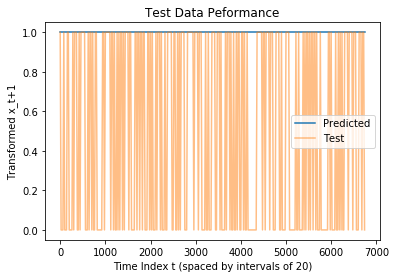

In [32]:
plt.plot(range(len(clf_pred))[0:-1:20], clf_pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test", alpha=0.5)
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

### Random Forest Classifier

In [36]:
depth_mse = np.zeros((8, 10))

for i, num_est in enumerate(range(22, 30)):
    for j, num_depth in enumerate(range(15, 25)):
        regr = RandomForestClassifier(max_depth = num_depth, n_estimators = num_est, random_state=2)
        regr.fit(X_train, np.ravel(y_train))
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        depth_mse[i][j] = mse
        print(num_est, num_depth, " ", end='')


22 15  22 16  22 17  22 18  22 19  22 20  22 21  22 22  22 23  22 24  23 15  23 16  23 17  23 18  23 19  23 20  23 21  23 22  23 23  23 24  24 15  24 16  24 17  24 18  24 19  24 20  24 21  24 22  24 23  24 24  25 15  25 16  25 17  25 18  25 19  25 20  25 21  25 22  25 23  25 24  26 15  26 16  26 17  26 18  26 19  26 20  26 21  26 22  26 23  26 24  27 15  27 16  27 17  27 18  27 19  27 20  27 21  27 22  27 23  27 24  28 15  28 16  28 17  28 18  28 19  28 20  28 21  28 22  28 23  28 24  29 15  29 16  29 17  29 18  29 19  29 20  29 21  29 22  29 23  29 24  

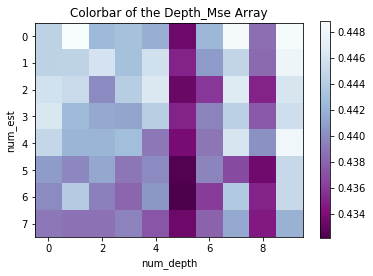

In [37]:
ax = plt.gca()

# Plot the heatmap
im = ax.imshow(depth_mse, cmap='BuPu_r')
ax.set_title("Colorbar of the Depth_Mse Array")
ax.set_xlabel("num_depth")
ax.set_ylabel("num_est")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

In [40]:
max_est = np.argmax(depth_mse)
i, j = np.unravel_index(depth_mse.argmin(), depth_mse.shape)
depth_mse[i, j]
print("At num_est: {} and at num_depth: {} we have MSE: {}".format(i+22, j+15, depth_mse[i, j]))

At num_est: 28 and at num_depth: 20 we have MSE: 0.4321042499629794


<b> Let's look at the predictions </b>

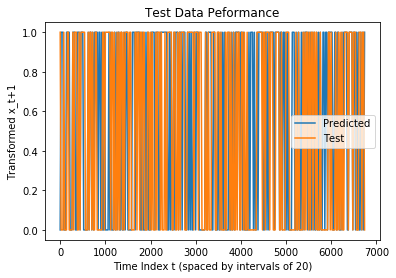

In [41]:
num_est = 28
num_depth = 20

regr = RandomForestClassifier(max_depth = num_depth, n_estimators = num_est, random_state=2)
regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test")
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [42]:
print("All Data Merged RandomForest Classifier MSE: {:.8f}".format(mse))

All Data Merged RandomForest Classifier MSE: 0.43210425


### Let's also try a RandomizedSearchedCV

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 86.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 162.4min finished
C:\Users\Abdurrahman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [45]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [47]:
random_pred = rf_random.best_estimator_.predict(X_test)
random_mse = mean_squared_error(y_test, random_pred)
print("Random Forest with Randomized Search Best MSE: {:.8f}".format(random_mse))

Random Forest with Randomized Search Best MSE: 0.40781875


<b> So compared to 0.43210425 we got with our parameter search of num_est and max_depth, we got a better score here. </b>

In [48]:
0.40781875 / 0.43210425

0.9437971276607439

# Train the Model and Save it for Loading

In [29]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [30]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}


for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]


In [31]:
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

(2501, 21)

In [32]:
all_data = companyData[0]
all_data.columns = list(range(21))
all_y = np.where(y>0, 1, 0)

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = np.concatenate((all_y , np.where(y>0, 1, 0)))

In [33]:
all_data.shape

(22509, 21)

In [34]:
all_y.shape

(22509, 1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0, random_state=42, shuffle=True)

In [36]:
params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

regr = RandomForestClassifier(**params, random_state=2)
regr.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [37]:
# import pickle
# # Commented out after saving...
# with open('./ClassificationModel', 'wb') as f:
#     pickle.dump(regr, f)

In [38]:
# in your prediction file
with open('./ClassificationModel', 'rb') as f:
    rf = pickle.load(f)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

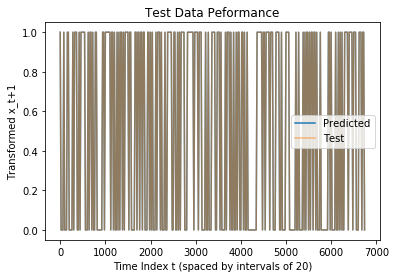

In [40]:
# Checking to make sure model is correct
pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)

plt.plot(range(len(pred))[0:-1:20], pred[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test", alpha=0.5)
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

In [41]:
mse

0.0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Using protocol -1 on pickle and gzip to compress files:

In [3]:
# # in your prediction file
# with open('./RegressionModel', 'rb') as f:
#     rf = pickle.load(f)

# with gzip.open('./RegressionModelGzipped', 'wb') as f:
#     pickle.dump(rf, f, protocol=-1)

In [ ]:
# # in your prediction file
# with open('./ClassificationModel', 'rb') as f:
#     rf = pickle.load(f)

# with gzip.open('./ClassificationModelGzipped', 'wb') as f:
#     pickle.dump(rf, f, protocol=-1)

## Part 4: Encapsulate the model and prediction steps into a function for the two best models found (use the exact 2 cells provided below to do this)

In [ ]:
import pickle
import gzip

In [5]:
def predict_price(X_train, y_train, X_test):
    # in your prediction file
    with gzip.open('./RegressionModelGzipped', 'rb') as f:
        rf = pickle.load(f)
    pred = rf.predict(X_test)
    
    return np.array(pred) #replace in np.array([]) with a numpy array of your predictions for y_hat_test

In [11]:
def predict_dir(X_train,y_train,X_test):

    # in your prediction file
    with gzip.open('./ClassificationModelGzipped', 'rb') as f:
        rf = pickle.load(f)
    pred = rf.predict(X_test)
    
    return np.array(pred) #replace in np.array([]) with a numpy array of your predictions for y_hat_test

# Test that function predict_price Works

In [7]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}

for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]
    
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

all_data = companyData[0]
all_data.columns = list(range(21))
all_y = y

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = pd.concat([all_y, y])
    
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

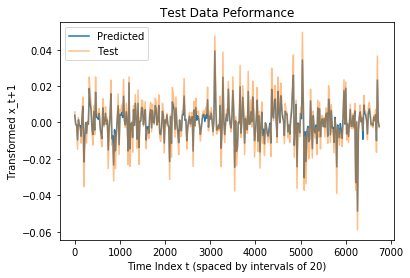

In [8]:
testing_preds = predict_price(X_train, y_train, X_test)
plt.plot(range(len(testing_preds))[0:-1:20], testing_preds[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test", alpha=0.5)
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

# Test that function predict_dir Works

In [12]:
# 9 companies, 9 * 21 columns = 189, 21 columns per company
companies = {}

for compNum, i in enumerate(range(0, len(X.columns.values), 21)):
    companies['comp{}'.format(compNum+1)] = X.columns.values[i:i+21]
    
# make new dataframes for each company
companyData = [None] * 9

for i in range(9):
    companyData[i] = X[companies['comp{}'.format(i+1)]]

companyData[0].shape

all_data = companyData[0]
all_data.columns = list(range(21))
all_y = np.where(y>0, 1, 0)

for each_comp in companyData[1:]:
    each_comp.columns = list(range(21))
    all_data = pd.concat([all_data, each_comp])
    all_y = np.concatenate((all_y , np.where(y>0, 1, 0)))
    
X_train, X_test, y_train, y_test = train_test_split(all_data, all_y, test_size=0.3, random_state=42, shuffle=True)

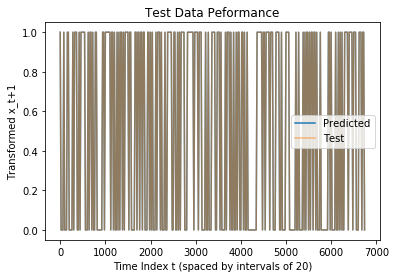

In [13]:
testing_preds = predict_dir(X_train, y_train, X_test)
plt.plot(range(len(testing_preds))[0:-1:20], testing_preds[0:-1:20], label="Predicted")
plt.plot(range(len(y_test))[0:-1:20], y_test[0:-1:20], label="Test", alpha=0.5)
plt.legend()
plt.title("Test Data Peformance")
plt.ylabel("Transformed x_t+1")
plt.xlabel("Time Index t (spaced by intervals of 20)")
plt.show()

# Since I trained them using full data, it's all very overfit at the moment. Which is fine since they gave good results with cross validation. Good luck code!